In [11]:
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, MaxPooling2D, Convolution2D, LSTM
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.regularizers import l2, l1
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.text import one_hot as oneHOT
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
import pandas as pd
import numpy as np
df_tweet = pd.read_csv("data/processed_tweet2.csv")
import ast
df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st1),axis =1)
df_tweet['tweet_pr_st2'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st2),axis =1)

df_tweet['subtask_a'] = df_tweet.apply(lambda x: 0 if x.subtask_a=='NOT' else 1,axis = 1)
df_tweet['subtask_b'] = df_tweet.apply(lambda x: 1 if x.subtask_b=='UNT' else 2 if x.subtask_b=='TIN' else 0,axis = 1)
df_tweet['subtask_c'] = df_tweet.apply(lambda x: 2 if x.subtask_c=='IND' else 3 if x.subtask_c=='GRP' else 4 if x.subtask_c =='OTH' else 0,axis = 1)



In [0]:
normalised_corpus = list(df_tweet['tweet_pr_st2'])
labels = list(df_tweet['subtask_a'])

In [0]:
normalised_corpus[:3]

In [0]:
import collections, itertools
word_counter = collections.Counter(list(itertools.chain.from_iterable(normalised_corpus)))

In [4]:
word_ids = list(set(list(itertools.chain.from_iterable(normalised_corpus))))
len(word_ids)

13910

In [0]:
word2idx = {}
word2idx = {token:id+3 for id,token in enumerate(word_ids)}
word2idx['<PAD>'] = 0
word2idx['<START>'] = 1
word2idx['<UNK>'] = 2
word2idx['<UNUSED>'] = 3

# word_index = {k:(v+3) for k,v in word_index.items()}
# word_index["<PAD>"] = 0
# word_index["<START>"] = 1
# word_index["<UNK>"] = 2  
# word_index["<UNUSED>"] = 3

In [0]:
idx2word = {v: k for k,v in word2idx.items()}

In [0]:
sents_as_ids = []
for i in range(len(normalised_corpus)):
    sents_as_ids.append([word2idx[j] for j in normalised_corpus[i]])

In [0]:
normalised_corpus[0:3]

In [0]:
sents_as_ids[0:3]

In [0]:
vocab_size = len(word_ids) + 3
maxlen=50

In [0]:
# def one_hot(labels):
#     from sklearn.preprocessing import OneHotEncoder
#     encoder = OneHotEncoder()
#     return encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

# labels = one_hot(labels)

In [0]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [0]:
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable)
    return embeddingLayer

In [0]:
train_data,test_data,train_labels,test_labels = train_test_split(sents_as_ids,labels,test_size=0.2,stratify=labels)

X_train_enc = pad_sequences(train_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=50)
X_test_enc = pad_sequences(test_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=50)


In [0]:
# put the code here
# !pip install chakin
# import chakin
# chakin.download(number=12, save_dir='./')

# import os
# os.system("unzip './glove.6B.zip' ")
from tensorflow.contrib.keras.api.keras.initializers import Constant
wordToIndex, indexToWord, wordToGlove = readGloveFile('glove.6B.300d.txt')
embeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable=True)
# os.system("rm 'embeddings/glove.6B.zip'")

In [0]:
# from keras.preprocessing.sequence import pad_sequences
# from sklearn.model_selection import train_test_split
# MAXIMUM_LENGTH = 500
# train_data,test_data,train_labels,test_labels = train_test_split(sents_as_ids,labels,test_size=0.2,stratify=labels)

# preprocessed_train_data = pad_sequences(train_data,maxlen=MAXIMUM_LENGTH)
# processed_test_data = pad_sequences(test_data,maxlen=MAXIMUM_LENGTH)

In [0]:
# print('Length of sample train_data before preprocessing:', len(train_data[1]), type(train_data[1]))

In [0]:
# print('Length of sample train_data after preprocessing:', len(preprocessed_train_data[1]), type(train_data[1]))

In [20]:
model = Sequential()
EMBED_SIZE = 100
model.add(embeddingLayer)
# model.add(Embedding(vocab_size,EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(1,activation='sigmoid',input_shape=(1,)))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# put the code here
# model = Sequential()
# model.add(Embedding(vocab_size, 30, input_length=MAXIMUM_LENGTH))
# model.add(Convolution1D(64,5,activation="relu"))
# model.add(Dropout(0.5))
# model.add(Convolution1D(32,3,activation="relu"))
# model.add(Dropout(0.5))
# model.add(Convolution1D(16,3,activation="sigmoid"))
# model.add(MaxPooling1D(5))
# model.add(Flatten())
# model.add(Dense(train_labels.shape[1],activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 120,160,801
Trainable params: 120,160,801
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model.fit(X_train_enc,
                    train_labels,
                    epochs=15,
                    batch_size=64,
                    validation_split=0.08,
                    verbose=1)





Train on 9706 samples, validate on 844 samples
Epoch 1/15




/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)





9706/9706 [==============================] - 44s 4ms/step - loss: 0.6412 - acc: 0.6652 - val_loss: 0.6320 - val_acc: 0.6742
Epoch 2/15
9706/9706 [==============================] - 28s 3ms/step - loss: 0.6382 - acc: 0.6662 - val_loss: 0.6306 - val_acc: 0.6742
Epoch 3/15
9706/9706 [==============================] - 28s 3ms/step - loss: 0.6362 - acc: 0.6661 - val_loss: 0.6276 - val_acc: 0.6742
Epoch 4/15
9706/9706 [==============================] - 28s 3ms/step - loss: 0.5687 - acc: 0.7117 - val_loss: 0.5435 - val_acc: 0.7630
Epoch 5/15
9706/9706 [==============================] - 28s 3ms/step - loss: 0.4477 - acc: 0.8042 - val_loss: 0.5296 - val_acc: 0.7547
Epoch 6/15
9706/9706 [==============================] - 28s 3ms/step - loss: 0.3606 - acc: 0.8599 - val_loss: 0.5656 - val_acc: 0.7678
Epoch 7/15
9706/9706 [==============================] - 28s 3ms/step - loss: 0.2938 - acc: 0.8946 - val_loss: 0.6129 - val_acc: 0.7453
Epoch 8/15
9706/9706 [==============================] - 28s 3ms

NameError: ignored

In [22]:
results = model.evaluate(X_test_enc, test_labels)
print(results)

2638/2638 [==============================] - 1s 416us/step
[0.910130309236149, 0.7179681577404129]


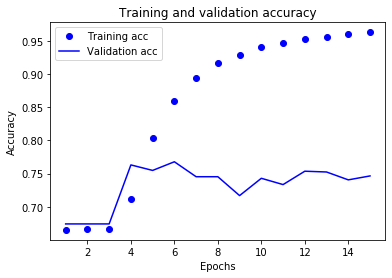

In [24]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
# put the code here
model = Sequential()
model.add(embeddingLayer)
# model.add(Convolution1D(64,5,activation="relu"))
# model.add(Dropout(0.5))
# model.add(Convolution1D(32,3,activation="relu"))
# model.add(Dropout(0.5))
# model.add(Convolution1D(16,3,activation="sigmoid"))
# model.add(MaxPooling1D(5))
# model.add(Flatten())
# model.add(Dense(train_labels.shape[1],activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.add(Dropout(0.2))
model.add(Convolution1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 120,162,465
Trainable params: 120,162,465
Non-trainable params: 0
________________________________________

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model.fit(X_train_enc,
                    train_labels,
                    epochs=5,
                    batch_size=256,
                    validation_split=0.2,
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)


Train on 8440 samples, validate on 2110 samples
Epoch 1/5
8440/8440 [==============================] - 11s 1ms/step - loss: 0.6451 - acc: 0.6604 - val_loss: 0.6340 - val_acc: 0.6668
Epoch 2/5
8440/8440 [==============================] - 6s 662us/step - loss: 0.6334 - acc: 0.6664 - val_loss: 0.6336 - val_acc: 0.6668
Epoch 3/5
8440/8440 [==============================] - 6s 661us/step - loss: 0.5948 - acc: 0.6925 - val_loss: 0.5662 - val_acc: 0.7166
Epoch 4/5
8440/8440 [==============================] - 6s 656us/step - loss: 0.4775 - acc: 0.7802 - val_loss: 0.5678 - val_acc: 0.7261
Epoch 5/5
8440/8440 [==============================] - 6s 662us/step - loss: 0.3539 - acc: 0.8531 - val_loss: 0.6243 - val_acc: 0.7346


In [19]:
results = model.evaluate(X_test_enc, test_labels)
print(results)

2638/2638 [==============================] - 0s 153us/step
[0.6401778528462584, 0.722137983230319]


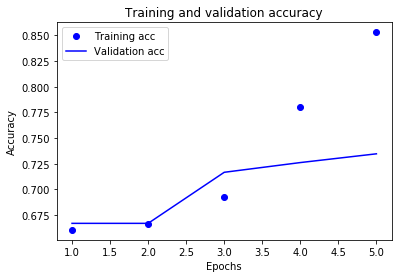

In [20]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()